# Changepoint Detection with Bayesian Inferenec - SPPT Example

Basic idea: look for a point where the global S value stops changing (i.e. becomes reasomably constant). This could be the point at which the resolution is 'optimal'

See the acompanying `spatial_resolution*.Rmd' for information about how the index was calculated.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import feather

import pymc3 as pm
import theano.tensor as tt

%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Data

Read the data (this was created by the `spatial_resolution*.Rmd` script)

In [73]:
data = feather.read_dataframe("./bner_results.feather")
num_cells = data.loc[:,['num.cells']].values
global_s =  data.loc[:,['global_s']].values

# Would also be useful to have a counter for the iteration number (there are multiple runs per cell size)
iterations = []
previous = num_cells[0]
counter = 0
for x in num_cells:
    if x != previous:
        counter += 1
        previous = x
    iterations.append(counter)

**XXXX HERE - ALSO NEED TO CALCULATE A *RATE OF CHANGE*. THIS IS WHAT WE ACTUALLY WANT TO MODEL, NOT THE S VALUES THEMSELVES.**

Estimate a rate of change as follows:

 -. For each iteration, take the euclidean difference between the results of the current iteration and the next 

Plot them

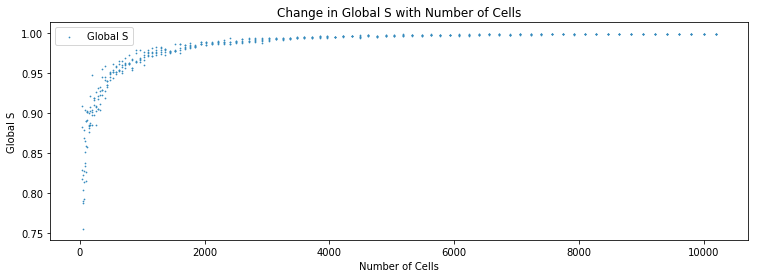

In [76]:
figsize(12.5, 4)
plt.scatter(num_cells[20:], global_s[20:], color="#348ABD", label="Global S", marker=".", s=2) 
plt.xlabel("Number of Cells")
plt.ylabel("Global S")
plt.title("Change in Global S with Number of Cells")
plt.legend()

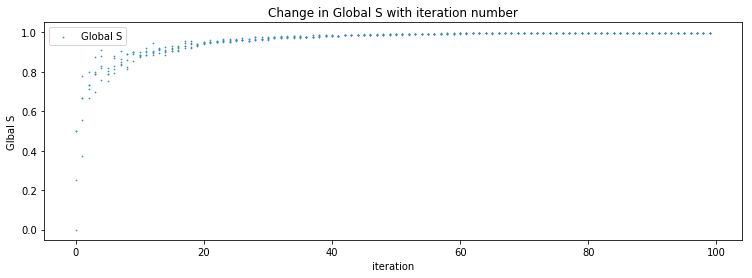

In [42]:
figsize(12.5, 4)
plt.scatter(iterations, global_s, color="#348ABD", label="Global S", marker=".", s=2) 
plt.xlabel("iteration")
plt.ylabel("Glbal S")
plt.title("Change in Global S with iteration number")
plt.legend()

## Model Conception

We want to model the Global S value. This is continuous must be positive, so use an exponential distribution:

$$Z \sim \text{Exp}(\lambda)$$


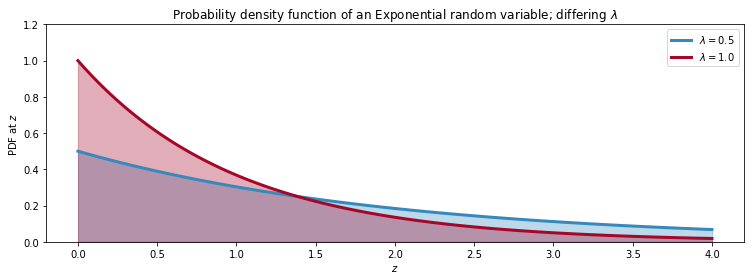

In [38]:
colours = ["#348ABD", "#A60628"]
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

We assume that the value of $\lambda$ changes at some point, called $\tau$, so in factt there are two $\lambda$ parameters, one before $\tau$ and one afterwards:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We also need to assign prior probabilities to the different possible values of $\lambda$. As this can be any positive number, use an  *exponential* distribution. This takes it's own parameter, $\alpha$ and $\beta$: (a *hyper parameters*)

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \beta )
\end{align}

## Model Definition

Now define the model using PYMC. (_Note that we use the same values for the hyperparameters, although above I talked about them as separate variables for each of the two Normal distributions_).

In [53]:
with pm.Model() as model:
    # The hyperparameters (apparently good to chose the mean of the observations as a starting point)
    alpha = 1.0/global_s.mean()
    beta  = 1.0/global_s.mean()

    # The two lambda parameters. (We want to see if their posterior distributions change)
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", beta)
    
    # Tau is the point at which the texting behaviour changed. We don't know anything about this 
    # so we assign a uniform prior belief
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(global_s) - 1)
    
    idx = np.arange(len(global_s)) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    # The observations
    observation = pm.Poisson("obs", lambda_, observed=global_s)

The model has been defined, now we can perform MCMC to sample from the posterior distribution

In [55]:
N = 20000 # Number of samples
with model:
    step = pm.Metropolis()
    start = pm.find_MAP() # Help it to start from a good place
    trace = pm.sample(N, tune=int(N*2), step=step, start=start, njobs=8)

logp = -6.1289, ||grad|| = 0.0001079: 100%|██████████| 35/35 [00:00<00:00, 688.65it/s]  
Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
100%|██████████| 60000/60000 [03:07<00:00, 320.52it/s]
The number of effective samples is smaller than 10% for some parameters.


The model has finished. Now example our samples.

Begin with a default plot provided by pymc

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bf8ceb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120c552b0>]], dtype=object)

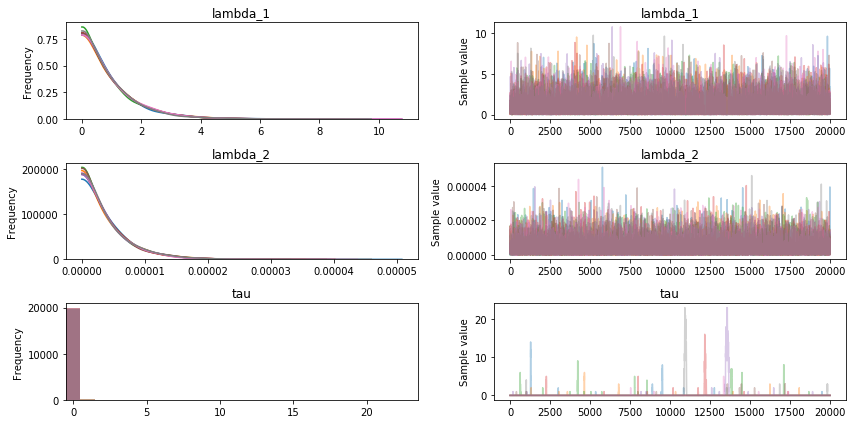

In [54]:
pm.plots.traceplot(trace=trace, varnames=["lambda_1", "lambda_2", "tau"])

In [56]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

Some bespoke plots.  These mostly just confirm what we suspected

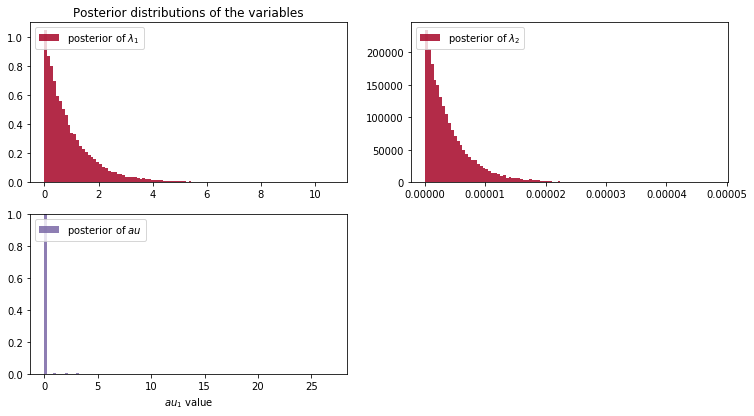

In [66]:
figsize(12.5, 10)
#histogram of the samples:

# Lambdas

ax = plt.subplot(321) # rows, columns, index
ax.set_autoscaley_on(True)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables""")
#plt.xlim([15, 30])
#plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(322) # rows, columns, index
ax.set_autoscaley_on(True)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_2$", color="#A60628", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
#plt.xlabel("$\lambda_1$ value")


# TAU
ax = plt.subplot(323)
ax.set_autoscaley_on(False)
plt.hist(tau_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\tau$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.xlabel("$\tau$ value")


Some more diagnostic visualisations

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12a9cc668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11c04f780>], dtype=object)

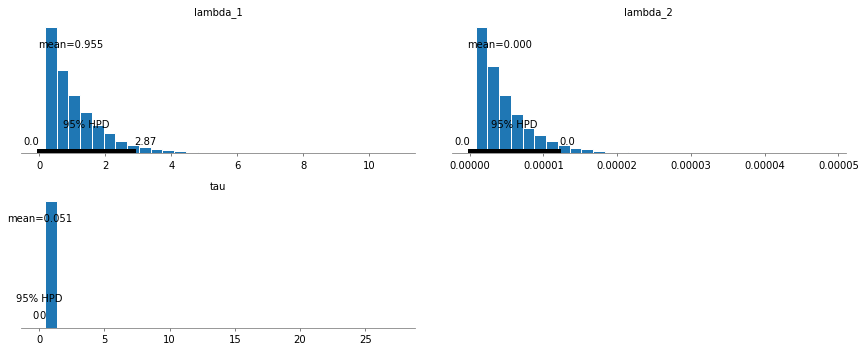

In [67]:
pm.plots.plot_posterior(trace=trace, varnames=["lambda_1", "lambda_2", "tau"])
#pm.plots.plot_posterior(trace=trace["centers"][:,1])
#pm.plots.autocorrplot(trace=trace, varnames=["centers"]);

## Sumary . Next steps:

This isnt particularly useful. The changepoint is detected to be at the beginning. Need to re-run with *rate of change*

Also could try dropping the first few points as these are when the number of cells is ridiculously low.